# Pose Estimation

**Purpose**: This notebook provides a walk through the process of estimating the position of individuals on an image with a pretrained lightweight OpenPose model proposed in (https://arxiv.org/pdf/1811.12004.pdf). For a more detailed explanation of the OpenPose pipeline, please refer to the original paper (https://arxiv.org/pdf/1812.08008.pdf).

## Package Import

In [1]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import urllib
import os

from models.with_mobilenet import PoseEstimationWithMobileNet
from modules.keypoints import extract_keypoints, group_keypoints
from modules.load_state import load_state
from modules.pose import Pose
from matplotlib import cm
from demo import extract_keypoints, group_keypoints, infer_fast

## Model Description

The Pose Estimation task aims to determine the position of the different body parts of individuals that can be found on an image.

While most of the Multi-Person Pose Estimation approaches have used a top-down strategy, that first detects where the persons are located and then estimates the pose of them at each location, the OpenPose model proposes to solve the task with a bottom-up approach.

A multi-stage CNN outputs confidence maps for body parts locations and vector fields that show the probable locations of body parts connections (limbs). These vector fields are called Part Affinity Fields (PAFs).

<img src="images/openpose_pipeline.png">

The OpenPose pipeline first performs a feature extraction step by feeding the image into a Convolutional Neural Network (CNN), generating a set of feature maps **F**.

The network produces a first-stage set of PAFs given **F**, and then performs $T_p - 1$ refinement iterations to obtain the final PAFs (for this workshop lightweight model, $T_p$ was set to 2):

$$\begin{align}
& \bf{L}^1 = \phi^1(\bf{F}) \\ 
& \bf{L}^t = \phi^t(\bf{F}, \bf{L}^{t-1}), \forall 2 \leq t \leq T_p
\end{align}$$

Then, the same process is repeated for creating the confidence maps:

$$\begin{align}
& \bf{S}^{1} = \rho^{1}(\bf{F}, \bf{L}^{T_p}) \\ 
& \bf{S}^t = \rho^t(\bf{F}, \bf{L}^{T_p}, \bf{S}^{t-1}), \forall 2 \leq t \leq T_p
\end{align}$$

<img src="images/openpose-body-architecture-1024x291.png">

We first download and load the pretrained CNN that does the PAFs and the body parts confidence maps extraction.

In [2]:
if not os.path.exists('model'):
    os.mkdir('model')

urllib.request.urlretrieve(
    "https://download.01.org/opencv/" +\
    "openvino_training_extensions/models/human_pose_estimation/checkpoint_iter_370000.pth",
                    "model/pretrained.pth")

net = PoseEstimationWithMobileNet()
checkpoint = torch.load('model/pretrained.pth', map_location='cpu')
load_state(net, checkpoint)
net = net.eval()

During this workshop, we will apply the OpenPose pipeline to the following image:

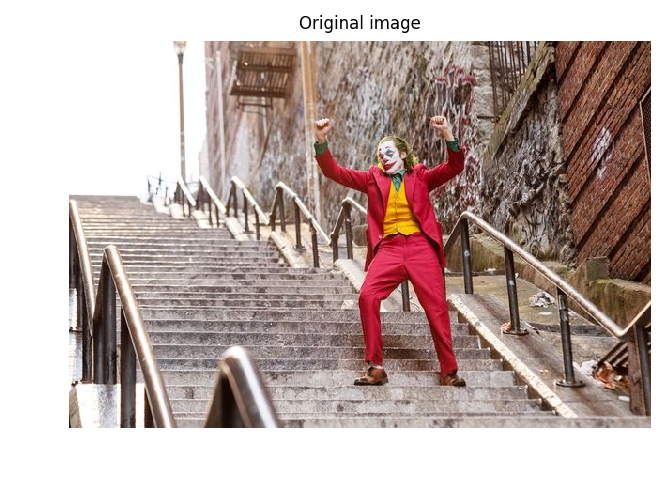

In [3]:
img_input = cv2.imread('images/joker.jpeg', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img_input, cv2.COLOR_BGR2RGB)

plt.figure(figsize=[5, 5], dpi=150)
plt.title('Original image', {'fontsize': 8})
plt.axis('off')
plt.imshow(img)

The `infer_fast` function takes as input the image and the pretrained model, and outputs the refined set of PAFs the refined set of body parts confidence maps.

In [5]:
stride = 8
upsample_ratio = 8
num_keypoints = Pose.num_kpts
orig_img = img.copy()
orig_img_shape = img.shape[1], img.shape[0]

heatmaps, pafs, scale, pad = infer_fast(net, input_img, 512, stride, upsample_ratio, cpu=True)

The `heatmaps` object contains the returned by the `infer_fast` function contains the heatmap of the location of each body part. The figure below shows which heatmap returned by the model corresponds to which point.

<img src="images/keypoints.png" width="250px">

In [ ]:
keypoints = {
    0: "nose", 1: "neck", 2: "left_shoulder", 3: "left_elbow", 4: "left_wrist", 5: "right_shoulder",
    6: "right_elbow", 7: "right_wrist", 8: "left_hip", 9: "left_knee", 10: "left_ankle", 11: "right_hip",
    12: "right_knee", 13: "right_ankle", 14: "left_eye", 15: "right_eye", 16: "left_ear", 17: "right_ear",
}

**TODO**: Now plot the heatmaps of the different bodyparts on the same image. The resulting picture should look similar to this:

<img src="images/heatmap_keypoints.png" />

In [ ]:
plt.figure(figsize=[5, 5], dpi=100)
plt.title('Heatmap of all the different keypoints')
plt.axis('off')
all_keypoints_heatmap = np.max(heatmaps[:,:,:18], axis=2) #all_keypoints_heatmap = ...
plt.imshow(cv2.resize(all_keypoints_heatmap, orig_img_shape))
plt.imshow(img_disp, alpha=0.3)

The PAFs are stored in the `pafs` object as vector fields. For each limb, the vectors are stored in two arrays: one for the x direction, and one for the y direction. We can thus draw the vectors on every pixels of the image to visualize the vector field:

In [ ]:
skip=(slice(None,None,2),slice(None,None,2))

plt.figure(figsize=[5, 5], dpi=150)
plt.title('Vector field of the PAF (Part Affinity Fields) for the right arm', {'fontsize': 10})
plt.axis('off')
plt.quiver(pafs[160:220, 320:420, 14][skip], - pafs[160:220, 320:420, 15][skip], color='cyan',scale=30)
plt.imshow(cv2.resize(img_disp, (776,512))[160:220, 320:420], extent=(-0.5, 50-0.5, 30-0.5, -0.5))

**TODO**: Now from this vector field that you see above, plot the heatmap corresponding to the magnitude of the vectors. The resulting image should look similar to this:

<img src="images/heatmap_paf.png"/>

In [ ]:
# Code here

'''
plt.figure(figsize=[5, 5], dpi=100)
plt.title('Heatmap of the PAF (Part Affinity Fields) for the right arm')
plt.axis('off')
plt.imshow(cv2.resize(np.abs(pafs[:,:,14]), orig_img_shape))
plt.imshow(img_disp, alpha=0.3)
'''

EXPLICATION ICI

<img src="images/keypoint_extraction.png">

Hereafter, you can see the different keypoints that can be detected and their respective IDs.

In [ ]:
total_keypoints_num = 0
all_keypoints_by_type = []
for kpt_idx in range(num_keypoints):  # 19th for bg
    total_keypoints_num += extract_keypoints(heatmaps[:, :, kpt_idx], all_keypoints_by_type, total_keypoints_num)

## Results analysis

### Number of keypoints per type

**TODO**: Now, list the number of keypoints per part (type) that have been detected, the output should be as follow:

```
['1 keypoints extracted for nose',
 '1 keypoints extracted for neck',
 '1 keypoints extracted for left_shoulder',
 '1 keypoints extracted for left_elbow',
 '1 keypoints extracted for left_wrist',
 '1 keypoints extracted for right_shoulder',
 '1 keypoints extracted for right_elbow',
 '1 keypoints extracted for right_wrist',
 '1 keypoints extracted for left_hip',
 '1 keypoints extracted for left_knee',
 '3 keypoints extracted for left_ankle',
 '1 keypoints extracted for right_hip',
 '1 keypoints extracted for right_knee',
 '3 keypoints extracted for right_ankle',
 '1 keypoints extracted for left_eye',
 '1 keypoints extracted for right_eye',
 '0 keypoints extracted for left_ear',
 '1 keypoints extracted for right_ear']
```

In [ ]:
# Code here

You should see that too many points are detected for the ankles. Namely, three instead of 1 per type.

**TODO**: Let's now see how it looks like on the original picture. The resulting picture should look similar to this

<img src="images/ankle_keypoints.png"/>

In [ ]:
# Code here

'''
img_with_ankle_keypoints = cv2.resize(img_disp.copy(), (776,512))

for ankle_keypoint in all_keypoints_by_type[10]:
    img_with_ankle_keypoints = cv2.circle(img_with_ankle_keypoints,
                                          ankle_keypoint[:2], 10, color=(0, 255, 255), thickness=-1)

plt.figure(figsize=[5, 5], dpi=100)
plt.title('Ankles keypoints detected')
plt.axis('off')
plt.imshow(img_with_ankle_keypoints)
'''

COMMENTAIRE ICI

In [ ]:
def get_positions(all_keypoints_by_type, pafs):
    pose_entries, all_keypoints = group_keypoints(all_keypoints_by_type, pafs, demo=True)
    for kpt_id in range(all_keypoints.shape[0]):
        all_keypoints[kpt_id, 0] = (all_keypoints[kpt_id, 0] * stride / upsample_ratio - pad[1]) / scale
        all_keypoints[kpt_id, 1] = (all_keypoints[kpt_id, 1] * stride / upsample_ratio - pad[0]) / scale
    current_poses = []
    for n in range(len(pose_entries)):
        if len(pose_entries[n]) == 0:
            continue
        pose_keypoints = np.ones((num_keypoints, 2), dtype=np.int32) * -1
        for kpt_id in range(num_keypoints):
            if pose_entries[n][kpt_id] != -1.0:  # keypoint was found
                pose_keypoints[kpt_id, 0] = int(all_keypoints[int(pose_entries[n][kpt_id]), 0])
                pose_keypoints[kpt_id, 1] = int(all_keypoints[int(pose_entries[n][kpt_id]), 1])
        pose = Pose(pose_keypoints, pose_entries[n][18])
        current_poses.append(pose)
        
    return current_poses

In [ ]:
all_positions = get_positions(all_keypoints_by_type, pafs)
colormap = cm.tab10.colors

img_final = img_disp.copy()

for i, pose in enumerate(all_positions):
    pose.draw(img_final, np.array(colormap[i % len(colormap)])*255)

In [ ]:
plt.figure(figsize=[5, 5], dpi=150)
plt.title('Resulting image with pose skeleton')
plt.axis('off')
plt.imshow(img_final)

# BONUS

## Multiple persons pose estimation

**TODO**: Run the pipeline on a picture containing multiple persons. Here is a beautiful picture if you are looking for inspiration ;)

In [ ]:
img = cv2.imread('images/multi_persons.jpg', cv2.IMREAD_COLOR)
bonus_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=[2,5], dpi=750)
plt.title('Beautiful image', fontdict = {'fontsize':2})
plt.axis('off')
plt.imshow(bonus_img)

In [ ]:
# Code here